#  **PROBLEMA DE LA MOCHILA CON GUROBI**
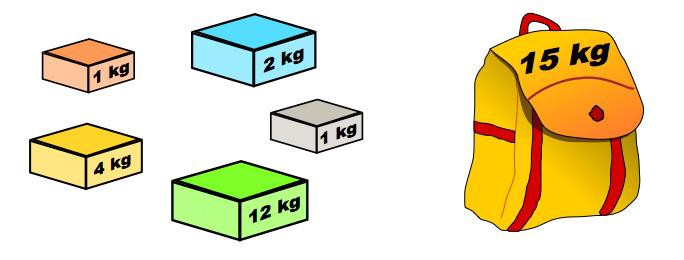

GRUPO 1 -> Prashant Jeswani Tejwani y José María Amusquivar Poppe

Se ha implementado el problema de la mochila mediante Gurobi. Debido a la licencia, no es posible ejecutar el Notebook aunque más adelante se mostrarán los resultados obtenidos.

Se leen e imprimen los ficheros del directorio.

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from gurobipy import * # import Gurobi 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Se implementa el método el cual generará el fichero de salida.

In [ ]:
from IPython.display import FileLink

def submission_generation(filename, str_output):
    os.chdir(r'/kaggle/working')
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for item in str_output:
            writer.writerow(item)
    return  FileLink(filename)

Se crea una tupla llamada *Item*, en el cual se almacenará cada elemento de la forma: 

*Item* -> (índice del elemento, valor del elemento, peso del elemento)

In [ ]:
import csv
from collections import namedtuple

Item = namedtuple("Item", ['index', 'value', 'weight'])

Se implementa el método *check_solution*, el cual comprobará si la suma de los pesos de los elementos escogidos son menores que la capacidad de la mochila (sumando 0.5 a los valores ya que a la hora de almacenar los elementos al principio, se restó).

In [ ]:
def check_solution(capacity, items, taken):
    weight = 0
    value = 0
    for item in items:
        if taken[item.index] == 1:
            weight += item.weight
            value += item.value+0.5
    if weight > capacity:
        print("solución incorrecta, se supera la capacidad de la mochila (capacity, weight):", capacity, weight)
        return 0
    return int(value)

Se crea el vector *taken* con la misma longitud que el vector de los elemento y los vectores *indices*, *valores* y *pesos*. 

Se crean dos diccionarios llamados *valoresDict* (clave = índice, valor = valor del elemento) y *pesosDict* (clave = índice, valor = peso del elemento) para poder hacer el producto entre la variable de decisión y los valores y pesos usando la herramienta tupledict.prod(), propia de Gurobi.

Se crea un modelo inicial (llamado "*mochila*"), y se crea la variable de decisión *x1* (binaria) la cual x[*i*] == 1 si se elige el elemento *i*. Se añade la restricción la cual limita que la suma de todos los pesos escogidos no excedan la capacidad máxima de la mochila. Se establece la función objetivo indicando que se maximice la suma de los valores escogidos.

Finalmente se escogen los elementos, formando el vector *taken* y se devuele.


In [ ]:
def gurobi(sortedItems, capacityI):
    taken = [0]*len(sortedItems)

    indices = [x[0] for x in sortedItems]
    valores = [x[1] for x in sortedItems]
    pesos = [x[2] for x in sortedItems]

    valoresDict = dict(zip(indices, valores))
    pesosDict = dict(zip(indices, pesos))

    m = Model("mochila")

    x1 = m.addVars(indices, vtype=GRB.BINARY, name="x")
    m.addConstr(x1.prod(pesosDict) <= capacityI)
    m.setObjective(x1.prod(valoresDict), GRB.MAXIMIZE)
    
    m.setParam(GRB.Param.PoolSolutions, 2048)
    m.setParam(GRB.Param.PoolGap, 0.01)
    m.setParam(GRB.Param.PoolSearchMode, 1)
    m.setParam(GRB.Param.TimeLimit, 10.0)
    #m.setParam("MipGapAbs", 0)
    
    m.optimize()

    for e in indices:
        if x1[e].x > 0.9:
            taken[e] = 1

    return taken

Se ordenan los elementos mediante valor/peso de forma ascendente. A continuación, se llama al método *gurobi* en el cual se hará uso de Gurobi para obtener el vector *taken* (vector de unos y ceros, siendo los elementos con valor uno los escogidos). Finalmente, se llama al método *check_solution* para la comprobación de los resultados y la obtención del valor de la mochila para preparar la solución en el formato de salida especificado (en el caso de que la solución no es válida, se abandona el programa). 

In [ ]:
def process(sortedItems, capacityI):

    sortedItems.sort(key=lambda x: x.value/x.weight)
    taken = gurobi(sortedItems, capacityI)
    maximo = check_solution(capacityI, sortedItems, taken)

    if maximo == 0:
        exit(1)

    # prepare the solution in the specified output format
    output_data = '%.2f' % maximo + ' ' + str(0) + '\n'
    output_data += ' '.join(map(str, taken))

    return output_data, maximo

Se parsea los datos, almacenando los elementos (en forma de tupla) de la mochila en el vector *items*, eliminando los elementos con valor negativo o con peso mayor que la mochila. 

Se resta 0.5 a los valores por si existe algún fichero el cual todos los elementos sean de la forma -> valor del elemento = peso del elemento. A continuación, se llama a la función *process* para resolver el problema.

In [ ]:
str_output = [["Filename","Max_value"]]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_name = dirname+'/'+filename
        with open(full_name, 'r') as input_data_file:
            input_data = input_data_file.read()
            lines = input_data.split('\n')
            
            # parse the input
            firstLine = lines[0].split()
            item_count = int(firstLine[0])
            capacity = int(firstLine[1])

            items = []
            j = 1
            for i in range(1, item_count + 1):
                line = lines[i]
                parts = line.split()
                if int(parts[1]) <= capacity and int(parts[0]) > 0:
                    items.append(Item(j - 1, int(parts[0])-0.5, int(parts[1])))
                    j = j + 1

            # call gurobi
            output, value = process(items, capacity)
            str_output.append([filename,str(value)])

Se llama a la función *submission_generation* para que genere el fichero de salida.

In [ ]:
submission_generation('Grupo1_Gurobi.csv', str_output)

Resultados obtenidos de los ficheros mediante la ejecución del código anterior:

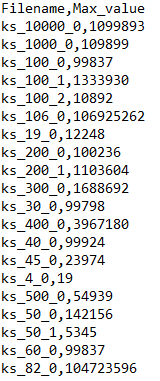